In [2]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  
from GPyOpt.methods import BayesianOptimization

Neural Network Model for Hyper Parameter Tuning

In [3]:
def benchmark(X, Y):
    return (X * np.sin(X)) + (Y * np.sin(Y))


In [4]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [5]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [6]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 18, pretrain_n)
Y = np.random.uniform(-5, 18, pretrain_n)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [7]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [8]:
df

x          y          z
0   4.591506   4.641474  -9.178355
1  11.567463  10.760049 -20.215970
2  -4.997369  -0.297598  -4.729201
3   1.953649  15.196701   9.125555
4  -1.624615  -4.370085  -2.404303
5  -2.876212  10.420753  -7.934456
6  -0.716015   4.598010  -4.114257
7   2.947897   7.849866   8.455922
8   4.125652  -1.771100  -1.685894
9   7.392785  -0.443666   6.783145

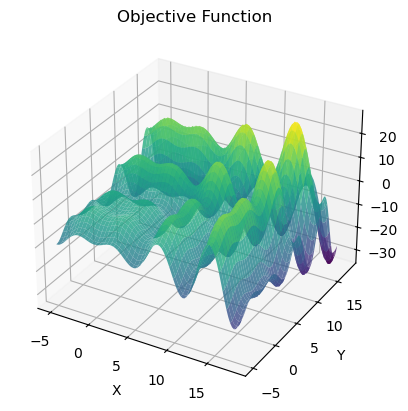

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 18, 100)
y_range = np.linspace(-5, 18, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Objective Function')

# Show the plot
plt.show()

In [10]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [11]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 14.28, "Y":  14.28, "Z": benchmark(14.28,  14.28)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

X      Y          Z
0  14.28  14.28  28.269165

In [12]:
def perform_iteration(df):

    def sim_all(x):
        df["a"] = x[0,0]
        df["b"] = x[0,1]
        df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
        df["diff"] = df["z"] - df["sim_z"]
        return (df["diff"]**2).sum()

    bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
            {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

    # Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
    bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
    bo.run_optimization(max_iter=max_bo_iter)
    df["a"] = bo.x_opt[0]
    df["b"] = bo.x_opt[1]
    print(bo.x_opt)

    # Create the grid of input values
    x_range = np.linspace(-5, 18, 100)
    y_range = np.linspace(-5, 18, 100)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

    # Create the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors')

    # Show the plot
    plt.show()

    # Generate 15 points using Latin Hypercube Sampling (LHS)
    n_samples = 90
    lhs= qmc.LatinHypercube(d=2, optimization="random-cd")
    lhs_samples = lhs.random(n=n_samples)
    bounds = np.array([[-5, 18], [-5, 18]])  # Bounds for Design Space

    scaled_samples = qmc.scale(lhs_samples, bounds[:, 0], bounds[:, 1])

    selected_points_df = pd.DataFrame(scaled_samples, columns=['x', 'y'])
    selected_points_df['sim_z'] = sim_eval(selected_points_df['x'], selected_points_df['y'], bo.x_opt[0], bo.x_opt[1])

    sim_df = df[["x", "y", "sim_z"]]
    sim_df = pd.concat([sim_df, selected_points_df], axis=0, ignore_index=True)
    
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=5, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the Dataset of Simulation Responses
    scaler = StandardScaler().fit(sim_df[['x', 'y']])
    X_scaled = scaler.transform(sim_df[['x', 'y']])

    # Train the best model on the combined standardized dataset
    best_model.fit(X_scaled, sim_df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Create a meshgrid and combine into a single array
    xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    xy_grid_scaled = scaler.transform(xy_grid)
    pred_mean, pred_std = mc_dropout_predictions(best_model, xy_grid_scaled)

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x_grid.shape)

    mean_surface = ax.plot_surface(x_grid, y_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x_grid, y_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x_grid, y_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Customize the plot
    ax.set_title('Neural Network of Simulated Response with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()
    
    x_range = [(-5, 18)]
    y_range = [(-5, 18)]
    def p_nn(xy):
        xy = np.array(xy).reshape(1, -1)  # Ensure correct shape (1,2)
        xy_scaled = scaler.transform(xy)
        pred_mean, pred_std = mc_dropout_predictions(best_model, xy_scaled)
        # Check if the point is inside the valid domain
        if (x_range[0][0] <= xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= xy[0, 1] <= y_range[0][1]):
            
            probability = max(pred_mean + 1.96 * pred_std - sim_df["sim_z"].median(), 1e-6)  # Avoid zero
            return probability
        else:
            return 1e-10  # Keep very small but nonzero probability for out-of-bounds case


    def metropolis_step(xy, sig):
        prop_xy = xy + np.random.normal(0, sig, size=xy.shape)  # Generate a candidate

        # Ensure proposed point is inside the valid bounds
        if not (x_range[0][0] <= prop_xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= prop_xy[0, 1] <= y_range[0][1]):
            return xy  # Reject out-of-bounds proposals

        u = np.random.uniform(0, 1)
        if u < min(1.0, p_nn(prop_xy) / p_nn(xy)):
            return prop_xy  # Accept move
        else:
            return xy  # Stay at current point


    def mh_sampler(sig, sample_size, burn_in, lag):
        # Start at the point with the largest simulated response
        max_idx = np.argmax(sim_df["sim_z"])
        x_init = sim_df["x"].iloc[max_idx]
        y_init = sim_df["y"].iloc[max_idx]
        xy = np.array([[x_init, y_init]])

        # Burn-in phase
        for i in range(burn_in):
            xy = metropolis_step(xy, sig)

        # Sampling phase
        output = xy
        for i in range(sample_size - 1):
            for j in range(lag):
                xy = metropolis_step(xy, sig)
            output = np.vstack((output, xy))  # Stack valid samples

        return output  # Returns an array of shape (sample_size, 2)

    # Use Metropolis-Hastings to sample new experimental points
    X_mh = mh_sampler(sig=5, sample_size=pretrain_n, burn_in=50, lag=20)

    # Convert MH samples to a DataFrame
    physical_test_points = pd.DataFrame(X_mh, columns=["x", "y"])

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x_grid, y_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Overlay sampled points
    plt.scatter(sim_df['x'], sim_df['y'], color='white', edgecolor='black', label='Simulation Sampled Points')
    plt.scatter(physical_test_points['x'], physical_test_points['y'], color='purple', edgecolor='black', label='Next Physical Test Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    physical_test_points["z"] = benchmark(physical_test_points['x'], physical_test_points['y']) + ran_err(pretrain_n, 0.05)
    physical_test_points["a"] = bo.x_opt[0]
    physical_test_points["b"] = bo.x_opt[1]
    physical_test_points["sim_z"] = sim_eval(physical_test_points["x"], physical_test_points["y"], physical_test_points["a"], physical_test_points["b"])
    physical_test_points["diff"] = physical_test_points["z"] - physical_test_points["sim_z"]

    # Heatmap of Simulated Points 
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the heatmap for sim_z_grid
    heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

    # Overlay scatter points for sampling points
    ax.scatter(df["x"], df["y"], color='blue', marker='o', label='Previous Sampled Points')
    ax.scatter(sim_df["x"], sim_df["y"], edgecolor='black', facecolors='none', marker='o', label='Sampled Simulation Points')
    ax.scatter(physical_test_points["x"], physical_test_points["y"], color='purple', marker='o', label='Next Physical Test Points')

    # Overlay scatter points for global maxima
    ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
    ax.legend()

    # Add a color bar
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Function Value (Z)')

    # Show the plot
    plt.show()

    # Add points to original dataframe
    df = pd.concat([df, physical_test_points], axis=0, ignore_index=True)

    return df

[ 2.73047019 -3.09689622]


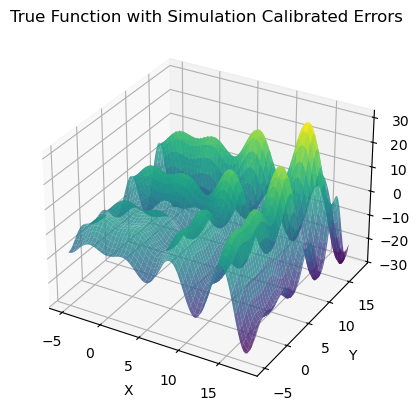

Best hyperparameters:
num_layers: 10
num_units: 50
learning_rate: 0.00032633490518424544
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 91.8979
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112.8503 
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90.5365 
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.0448
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101.7331 
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.0051 
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92.2105 
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89.3193 
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 93.8208 
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 91.3240 
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99.4334 
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.8559 
Epoch 13/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89.5167 
Epo

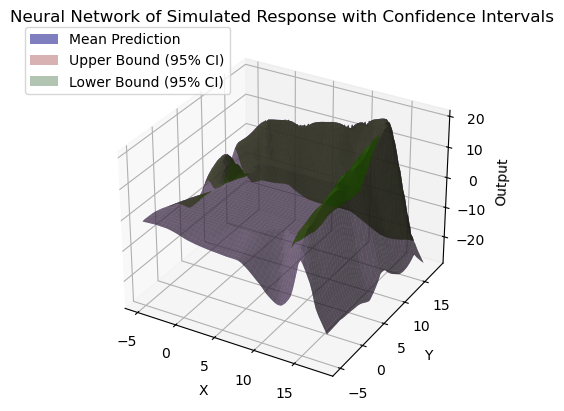

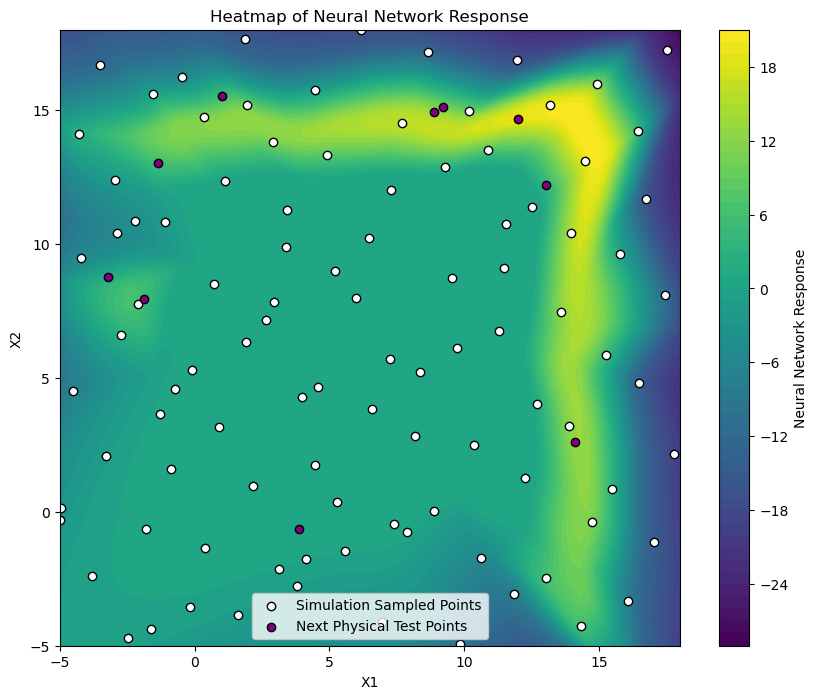

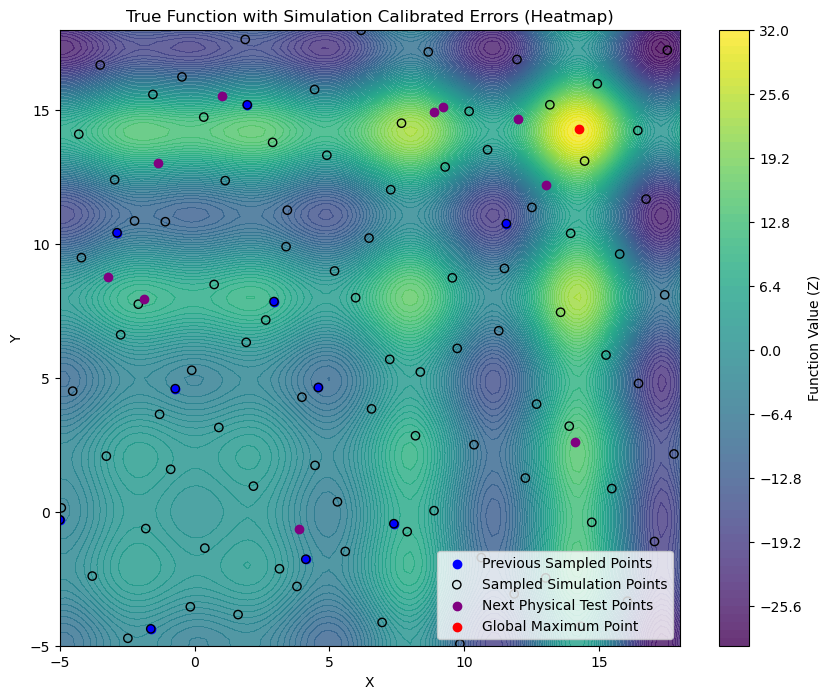

            x          y          z        a         b      sim_z      diff
0    4.591506   4.641474  -9.178355  2.73047 -3.096896  -9.561388  0.383033
1   11.567463  10.760049 -20.215970  2.73047 -3.096896 -18.981988 -1.233982
2   -4.997369  -0.297598  -4.729201  2.73047 -3.096896  -3.511473 -1.217728
3    1.953649  15.196701   9.125555  2.73047 -3.096896   9.891099 -0.765544
4   -1.624615  -4.370085  -2.404303  2.73047 -3.096896  -1.881428 -0.522875
5   -2.876212  10.420753  -7.934456  2.73047 -3.096896  -8.135435  0.200979
6   -0.716015   4.598010  -4.114257  2.73047 -3.096896  -4.002058 -0.112200
7    2.947897   7.849866   8.455922  2.73047 -3.096896   8.504247 -0.048325
8    4.125652  -1.771100  -1.685894  2.73047 -3.096896  -2.840597  1.154703
9    7.392785  -0.443666   6.783145  2.73047 -3.096896   5.045118  1.738027
10  -1.887516   7.961656   9.756602  2.73047 -3.096896   9.193312  0.563289
11   8.881183  14.924176  15.162864  2.73047 -3.096896  16.901655 -1.738791
12   9.22294

In [13]:
df = perform_iteration(df)
print(df)


[ 1.92974782 -3.14276314]


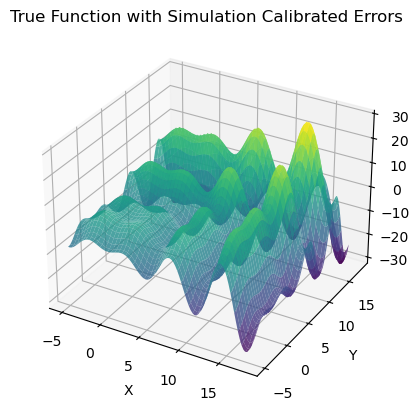

Best hyperparameters:
num_layers: 7
num_units: 50
learning_rate: 0.0013748326824141333
dropout_rate: 0.03953140008352785
batch_size: 104
epochs: 191
Epoch 1/191
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 103.4589
Epoch 2/191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 103.0153 
Epoch 3/191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100.5403
Epoch 4/191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 104.4419 
Epoch 5/191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 102.9645 
Epoch 6/191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 104.1813 
Epoch 7/191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 101.8186 
Epoch 8/191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 103.2417 
Epoch 9/191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 100.6197
Epoch 10/191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102.0948 
Epoch 11/191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 102.2106 
Epoch 12/191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102.2599 
Epoch 13/191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

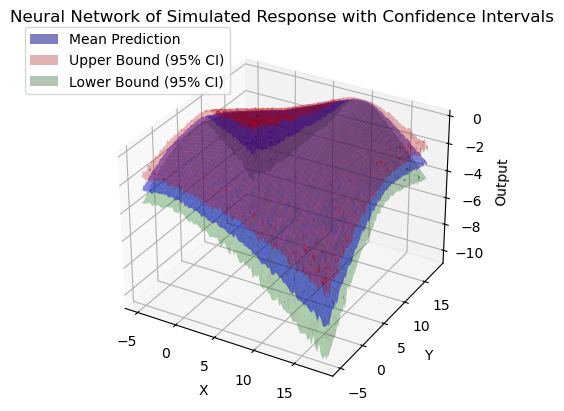

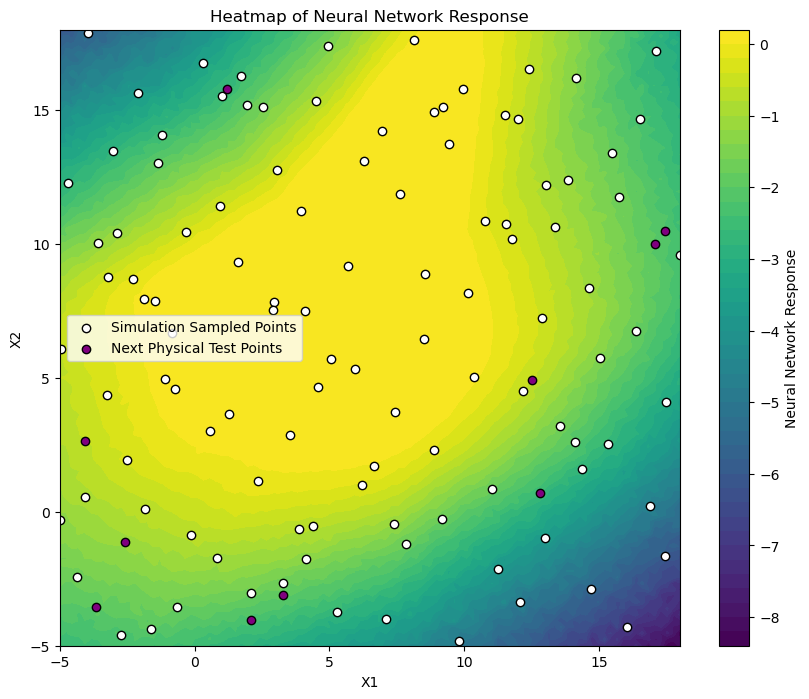

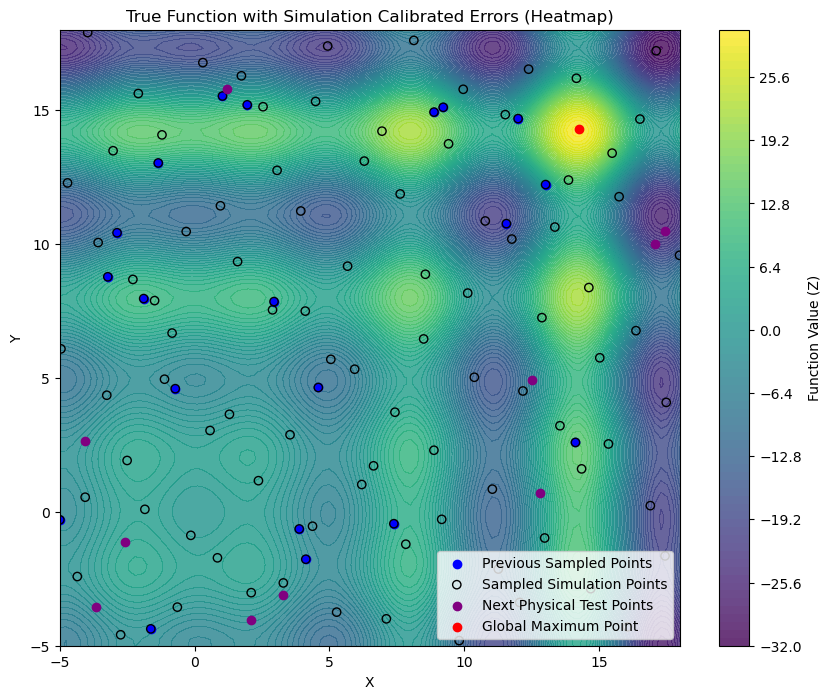

In [14]:
df = perform_iteration(df)

[ 2.16680332 -3.14047835]


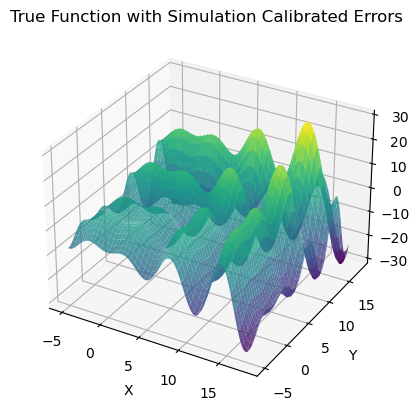

Best hyperparameters:
num_layers: 3
num_units: 50
learning_rate: 0.002488743595615416
dropout_rate: 0.5
batch_size: 143
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 96.9327
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 97.4929
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 97.1912
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 96.5243
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 98.0158
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 96.3469
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 95.8583
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 95.1899
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 96.4455
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 96.0560
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 94.4978
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 96.2773
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 95.3086
Epoch 14

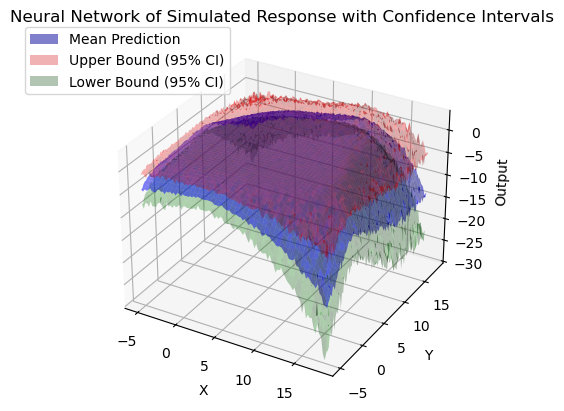

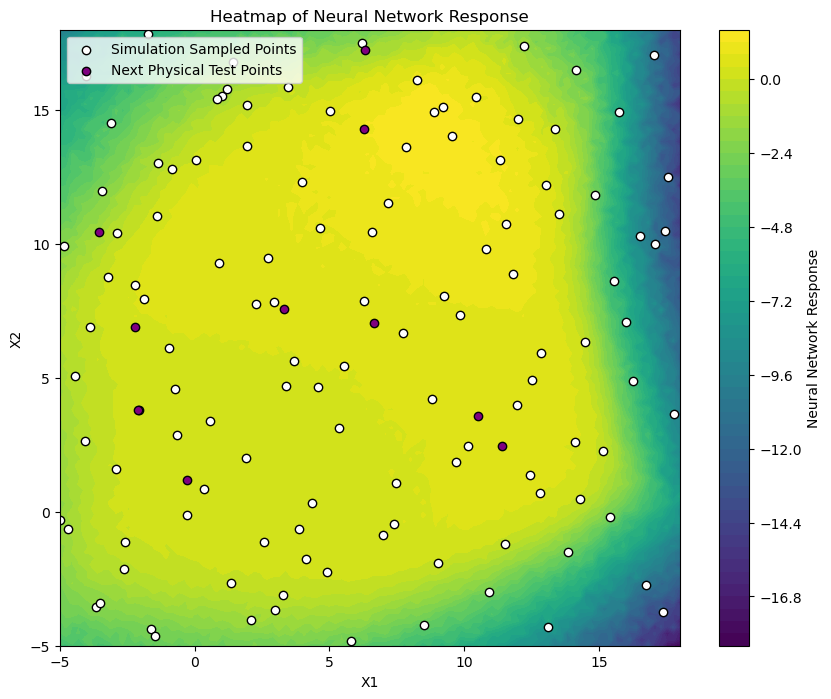

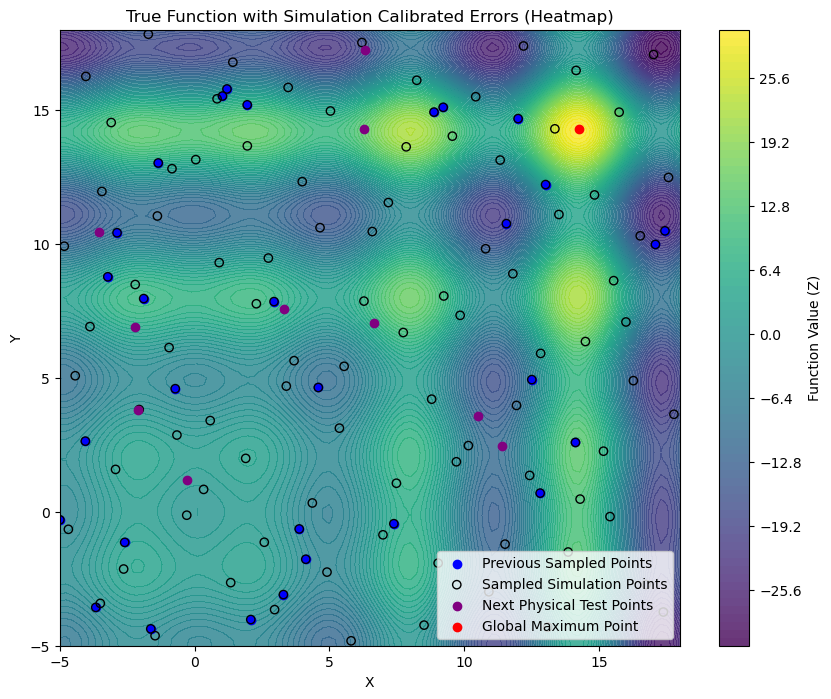

            x          y          z         a         b      sim_z      diff
0    4.591506   4.641474  -9.178355  2.166803 -3.140478  -9.392762  0.214407
1   11.567463  10.760049 -20.215970  2.166803 -3.140478 -19.045102 -1.170867
2   -4.997369  -0.297598  -4.729201  2.166803 -3.140478  -3.912509 -0.816692
3    1.953649  15.196701   9.125555  2.166803 -3.140478   8.133643  0.991912
4   -1.624615  -4.370085  -2.404303  2.166803 -3.140478  -2.176296 -0.228007
5   -2.876212  10.420753  -7.934456  2.166803 -3.140478  -9.263158  1.328702
6   -0.716015   4.598010  -4.114257  2.166803 -3.140478  -4.243038  0.128781
7    2.947897   7.849866   8.455922  2.166803 -3.140478   8.215644  0.240278
8    4.125652  -1.771100  -1.685894  2.166803 -3.140478  -2.556944  0.871050
9    7.392785  -0.443666   6.783145  2.166803 -3.140478   5.607104  1.176041
10  -1.887516   7.961656   9.756602  2.166803 -3.140478   9.073723  0.682879
11   8.881183  14.924176  15.162864  2.166803 -3.140478  16.124428 -0.961564

In [15]:
df = perform_iteration(df)
print(df)

[ 2.21844047 -3.17291335]


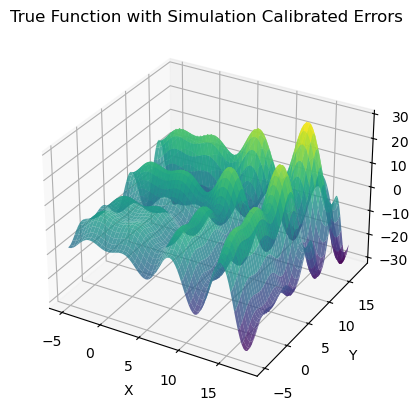

Best hyperparameters:
num_layers: 6
num_units: 50
learning_rate: 0.008636191252640025
dropout_rate: 0.15917366916648817
batch_size: 42
epochs: 105
Epoch 1/105
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 87.9363
Epoch 2/105
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84.4895 
Epoch 3/105
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90.8056 
Epoch 4/105
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88.4100 
Epoch 5/105
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92.6608  
Epoch 6/105
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90.7613  
Epoch 7/105
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77.0954 
Epoch 8/105
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81.5905 
Epoch 9/105
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77.7020 
Epoch 10/105
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84.7805 
Epoch 11/105
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78.4683 
Epoch 12/105
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79.3347 
Epoch 13/105
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

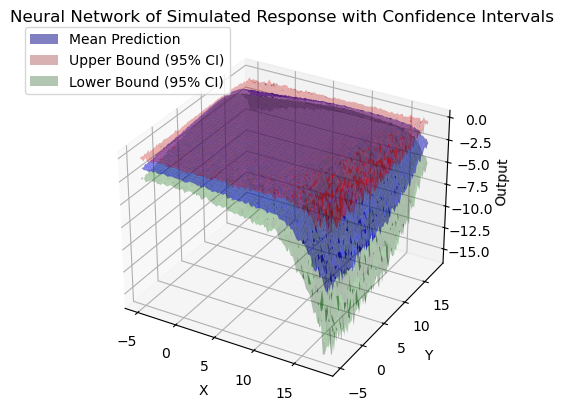

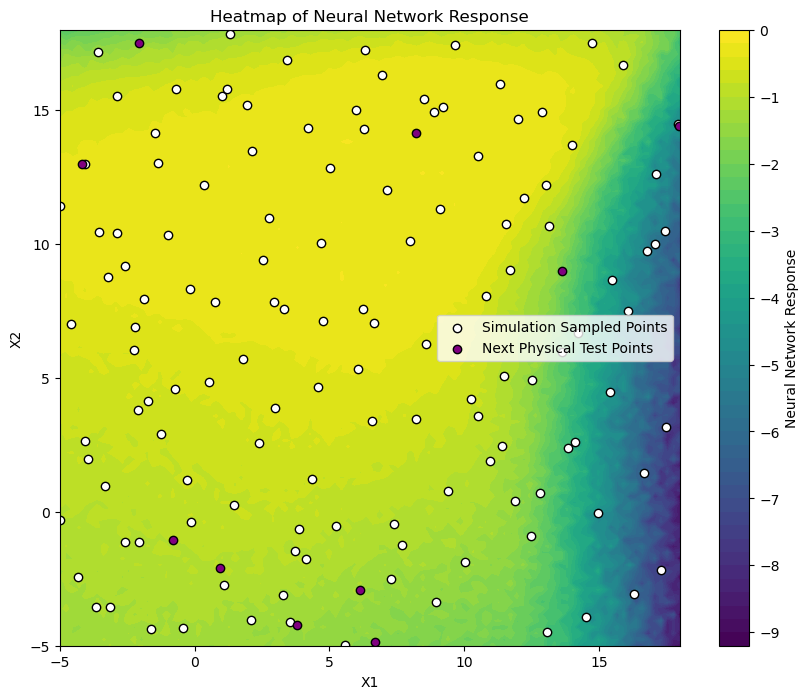

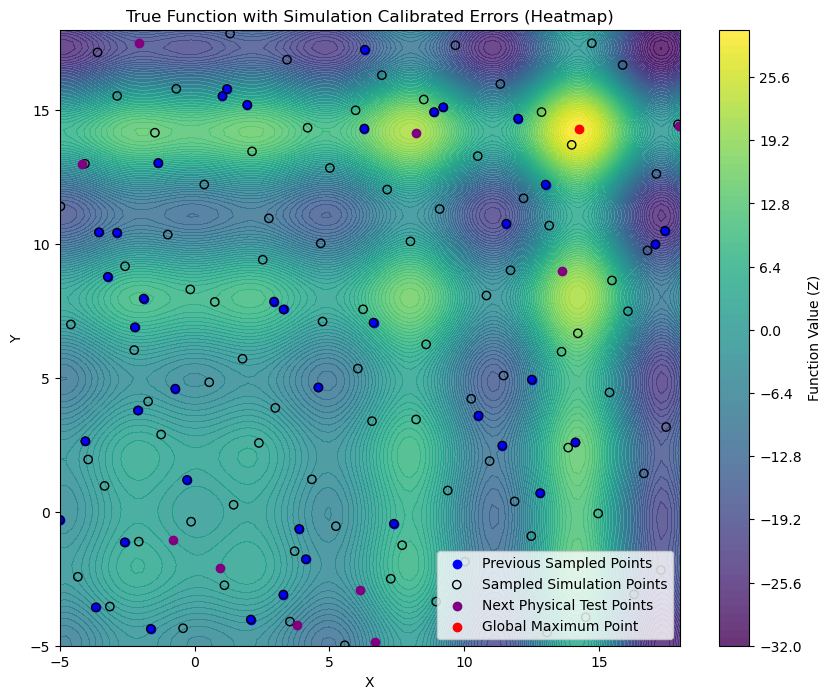

            x          y          z        a         b      sim_z      diff
0    4.591506   4.641474  -9.178355  2.21844 -3.172913  -9.587532  0.409177
1   11.567463  10.760049 -20.215970  2.21844 -3.172913 -19.706063 -0.509907
2   -4.997369  -0.297598  -4.729201  2.21844 -3.172913  -3.768212 -0.960989
3    1.953649  15.196701   9.125555  2.21844 -3.172913   7.431063  1.694492
4   -1.624615  -4.370085  -2.404303  2.21844 -3.172913  -2.183264 -0.221039
5   -2.876212  10.420753  -7.934456  2.21844 -3.172913  -9.483544  1.549088
6   -0.716015   4.598010  -4.114257  2.21844 -3.172913  -4.282165  0.167908
7    2.947897   7.849866   8.455922  2.21844 -3.172913   7.956835  0.499087
8    4.125652  -1.771100  -1.685894  2.21844 -3.172913  -2.686763  1.000870
9    7.392785  -0.443666   6.783145  2.21844 -3.172913   5.390374  1.392771
10  -1.887516   7.961656   9.756602  2.21844 -3.172913   8.950757  0.805845
11   8.881183  14.924176  15.162864  2.21844 -3.172913  15.243078 -0.080214
12   9.22294

In [16]:
df = perform_iteration(df)
print(df)

[ 2.02324962 -3.1150179 ]


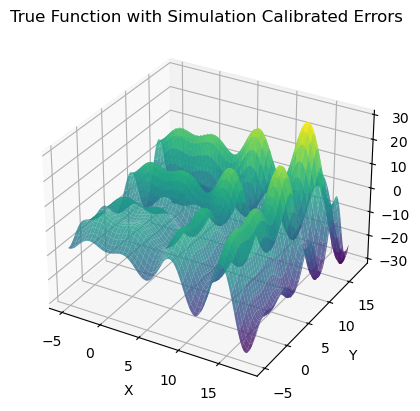

Best hyperparameters:
num_layers: 7
num_units: 154
learning_rate: 0.0005470959621924694
dropout_rate: 0.0
batch_size: 111
epochs: 163
Epoch 1/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 113.9925
Epoch 2/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 115.5613 
Epoch 3/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 114.3219 
Epoch 4/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 116.6361 
Epoch 5/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 113.7714 
Epoch 6/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 115.5300 
Epoch 7/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 114.7524 
Epoch 8/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 113.0797 
Epoch 9/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 108.4308 
Epoch 10/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 108.2931 
Epoch 11/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 111.8624 
Epoch 12/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 108.0405 
Epoch 13/163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11

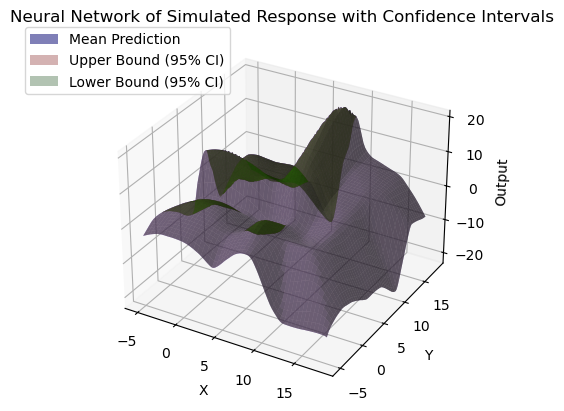

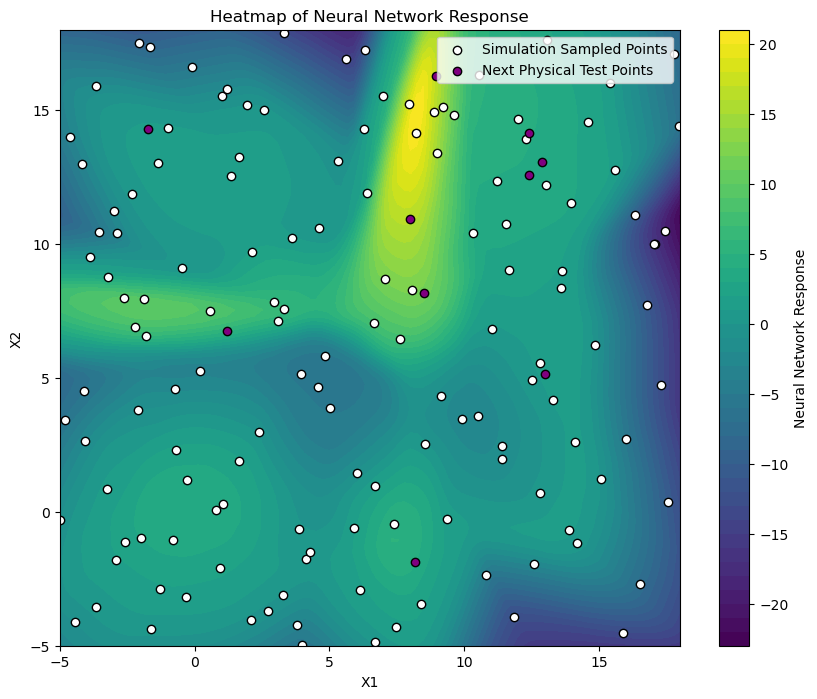

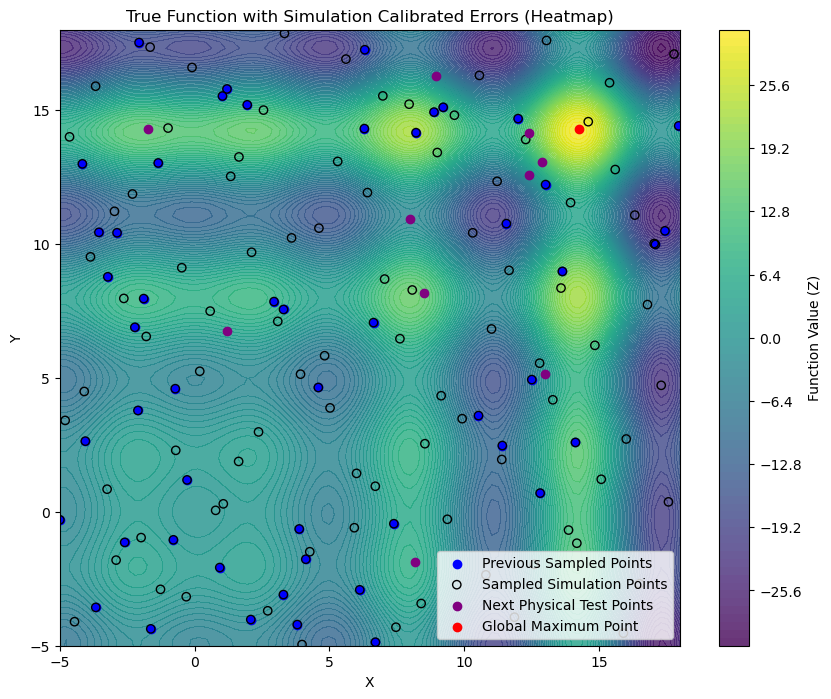

            x          y          z        a         b      sim_z      diff
0    4.591506   4.641474  -9.178355  2.02325 -3.115018  -9.011001 -0.167354
1   11.567463  10.760049 -20.215970  2.02325 -3.115018 -18.077137 -2.138833
2   -4.997369  -0.297598  -4.729201  2.02325 -3.115018  -4.305018 -0.424183
3    1.953649  15.196701   9.125555  2.02325 -3.115018   8.365165  0.760390
4   -1.624615  -4.370085  -2.404303  2.02325 -3.115018  -2.293125 -0.111178
5   -2.876212  10.420753  -7.934456  2.02325 -3.115018  -9.454145  1.519689
6   -0.716015   4.598010  -4.114257  2.02325 -3.115018  -4.286497  0.172240
7    2.947897   7.849866   8.455922  2.02325 -3.115018   8.477443 -0.021521
8    4.125652  -1.771100  -1.685894  2.02325 -3.115018  -2.217861  0.531967
9    7.392785  -0.443666   6.783145  2.02325 -3.115018   6.207009  0.576136
10  -1.887516   7.961656   9.756602  2.02325 -3.115018   8.948748  0.807854
11   8.881183  14.924176  15.162864  2.02325 -3.115018  16.908414 -1.745550
12   9.22294

In [17]:
df = perform_iteration(df)
print(df)

[ 1.75076844 -3.14182162]


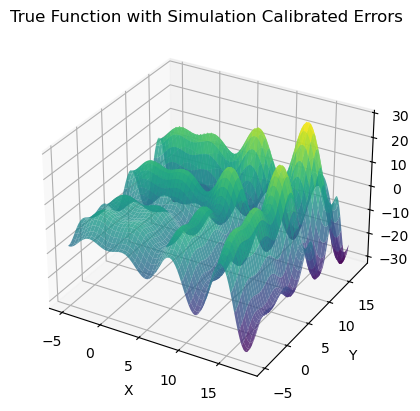

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.0652225586108875
dropout_rate: 0.0
batch_size: 20
epochs: 168
Epoch 1/168
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 190.6096  
Epoch 2/168
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 188.3197 
Epoch 3/168
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142.8321
Epoch 4/168
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148.6392
Epoch 5/168
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 173.3641 
Epoch 6/168
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 178.5532 
Epoch 7/168
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142.6021 
Epoch 8/168
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160.2588
Epoch 9/168
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157.5970 
Epoch 10/168
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120.0333
Epoch 11/168
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128.0918
Epoch 12/168
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147.2479
Epoch 13/168
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 147.0590


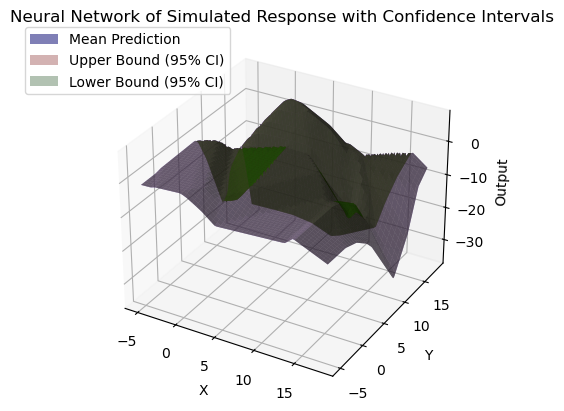

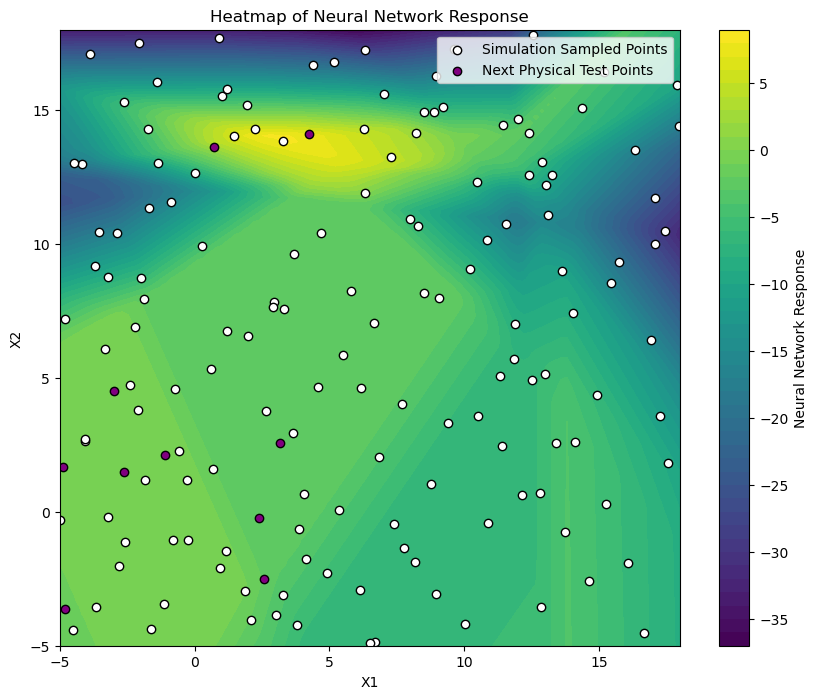

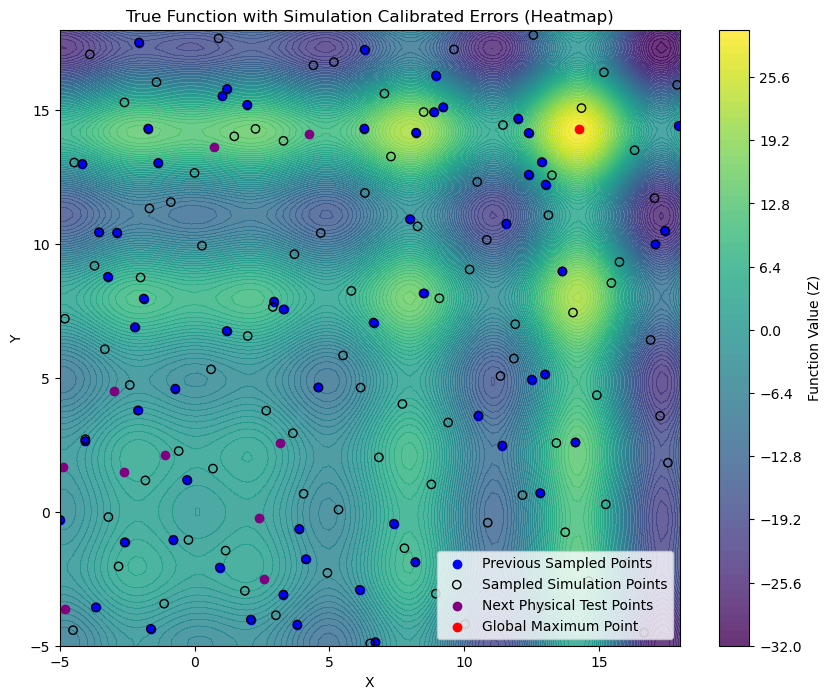

            x          y          z         a         b      sim_z       diff
0    4.591506   4.641474  -9.178355  1.750768 -3.141822 -16.531796   7.353441
1   11.567463  10.760049 -20.215970  1.750768 -3.141822 -41.779345  21.563375
2   -4.997369  -0.297598  -4.729201  1.750768 -3.141822   2.043271  -6.772473
3    1.953649  15.196701   9.125555  1.750768 -3.141822 -12.020447  21.146002
4   -1.624615  -4.370085  -2.404303  1.750768 -3.141822  -1.711160  -0.693143
..        ...        ...        ...       ...       ...        ...        ...
65   2.401441  -0.244533   1.671800  1.750768 -3.141822   1.109334   0.562465
66   4.243162  14.118310  10.335566  1.750768 -3.141822   9.749390   0.586177
67   3.165073   2.562658   1.322431  1.750768 -3.141822   0.801447   0.520984
68  -2.605759   1.502235   2.794353  1.750768 -3.141822   3.270537  -0.476184
69   2.566871  -2.514201   2.791057  1.750768 -3.141822   2.044277   0.746780

[70 rows x 7 columns]


In [18]:
df = perform_iteration(df)
print(df)